# Modélisation de la série temporelle correspondant à l'indice boursière de l'entreprise Tesla.

In [1]:
# Bibliothèques
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from math import sqrt, floor
from matplotlib.backends.backend_pdf import PdfPages
import scipy.stats as st
from scipy.stats import shapiro, skew, kurtosis
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

In [2]:
import logging
import warnings
warnings.filterwarnings('ignore')
# pd.set_option('display.max_colwidth', None)
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
pd.reset_option('display')

## Étape 1: Téléchargement des données de Tesla et analyse exploratoire

In [3]:
logging.basicConfig(level=logging.DEBUG)

# Définition de la période de récupération des données
start_date = '2020-01-01'  # Vous pouvez modifier cette date selon vos besoins
end_date = datetime.now().strftime('%Y-%m-%d')  # Date actuelle formatée comme YYYY-MM-DD

# Téléchargement des données pour Tesla (TSLA)
tesla_data = yf.download('TSLA', start=start_date, end=end_date)

DEBUG:yfinance:Entering download()
DEBUG:yfinance:Disabling multithreading because DEBUG logging enabled
DEBUG:yfinance: Entering history()
DEBUG:peewee:('CREATE TABLE IF NOT EXISTS "_kv" ("key" VARCHAR(255) NOT NULL PRIMARY KEY, "value" VARCHAR(255)) WITHOUT ROWID', [])
DEBUG:peewee:('SELECT "t1"."key", "t1"."value" FROM "_kv" AS "t1" WHERE ("t1"."key" = ?) LIMIT ? OFFSET ?', ['TSLA', 1, 0])
DEBUG:yfinance:  Entering history()
DEBUG:yfinance:TSLA: Yahoo GET parameters: {'period1': '2020-01-01 00:00:00-05:00', 'period2': '2024-10-20 00:00:00-04:00', 'interval': '1d', 'includePrePost': False, 'events': 'div,splits,capitalGains'}
DEBUG:yfinance:   Entering get()
DEBUG:yfinance:url=https://query2.finance.yahoo.com/v8/finance/chart/TSLA
DEBUG:yfinance:params=frozendict.frozendict({'period1': 1577854800, 'period2': 1729396800, 'interval': '1d', 'includePrePost': False, 'events': 'div,splits,capitalGains'})
DEBUG:yfinance:    Entering _get_cookie_and_crumb()
DEBUG:yfinance:cookie_mode = 'bas

##### Cette étude sera faite en fonction de la valeur de clôture de l'action.

In [4]:
var="Close"

##### Visualisation des prix de clôture

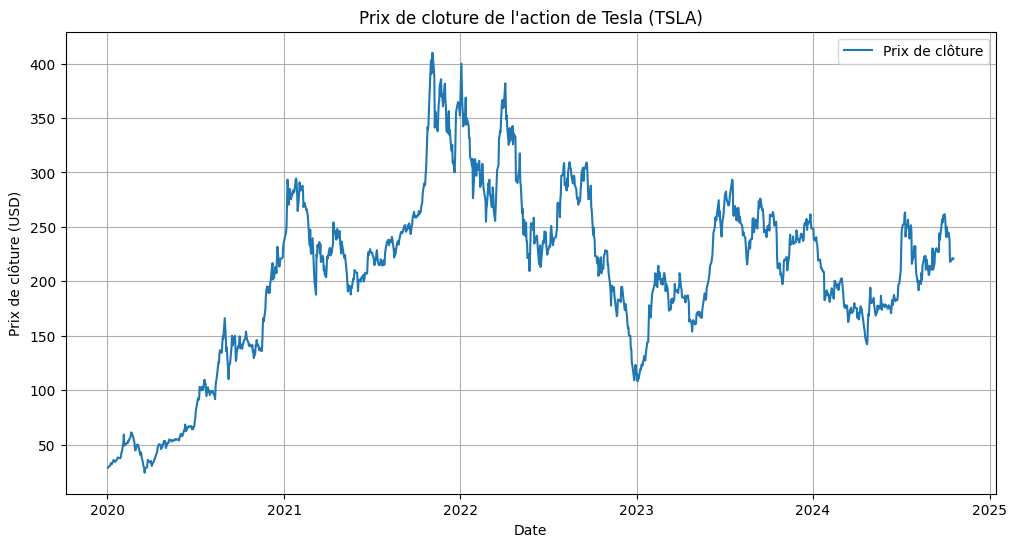

In [6]:
###      !!! Lancer la visualisation 2 fois pour supprimer les warnings !!!

plt.figure(figsize=(12, 6))
plt.plot(tesla_data[var], label='Prix de clôture')
plt.title('Prix de cloture de l\'action de Tesla (TSLA)')
plt.xlabel('Date')
plt.ylabel('Prix de clôture (USD)')
plt.legend()
plt.grid(True)
plt.show()

##### Reajustement de la série temporelle observée et création d'une seconde variable :

In [8]:
tesla_data_2 = tesla_data.loc[tesla_data[tesla_data[var] == tesla_data[var].max()].index[0]:end_date,]

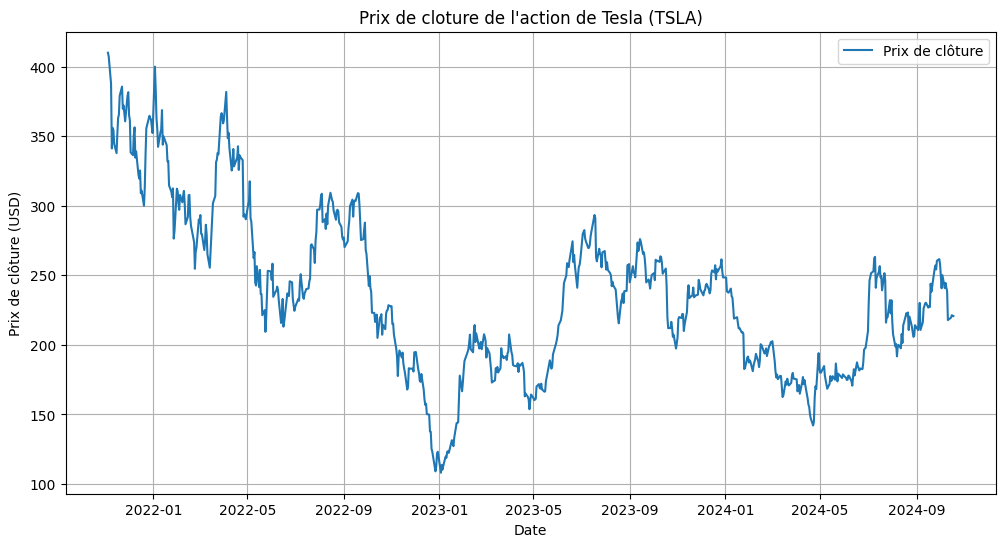

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(tesla_data_2[var], label='Prix de clôture')
plt.title('Prix de cloture de l\'action de Tesla (TSLA)')
plt.xlabel('Date')
plt.ylabel('Prix de clôture (USD)')
plt.legend()
plt.grid(True)
plt.show()

##### Dimensions des deux dataframes :

In [11]:
print(tesla_data.shape)
print(tesla_data_2.shape)

(1208, 6)
(743, 6)


##### Nom des colonnes

In [12]:
tesla_data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

##### Type de données de l'index : datetimes

In [16]:
type(tesla_data.index)

pandas.core.indexes.datetimes.DatetimeIndex

##### Echantillon des données

In [13]:
tesla_data.sample(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-11-14,235.029999,238.139999,230.720001,237.410004,237.410004,149771600
2021-08-12,235.446671,240.933334,233.133331,240.750000,240.750000,52377300
2023-01-25,141.910004,146.410004,138.070007,144.429993,144.429993,192734300
2023-01-03,118.470001,118.800003,104.639999,108.099998,108.099998,231402800
2021-11-02,386.453339,402.863342,382.000000,390.666656,390.666656,128213400
2022-07-27,263.809998,275.926666,261.790009,274.820007,274.820007,88110000
2024-03-11,175.449997,182.869995,174.800003,177.770004,177.770004,85391500
2023-11-13,215.600006,225.399994,211.610001,223.710007,223.710007,140447600
2022-07-12,236.846664,239.773331,228.369995,233.070007,233.070007,87930900


##### Informations sur les données du dataframe :
Dates entre le 2020-01-02 et le 2024-05-15</br>
Il n'y a aucune valeur manquante</br>
Que des valeurs numériques hormis l'index</br>

In [15]:
tesla_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1208 entries, 2020-01-02 to 2024-10-18
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1208 non-null   float64
 1   High       1208 non-null   float64
 2   Low        1208 non-null   float64
 3   Close      1208 non-null   float64
 4   Adj Close  1208 non-null   float64
 5   Volume     1208 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 98.4 KB


In [14]:
tesla_data_2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 743 entries, 2021-11-04 to 2024-10-18
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       743 non-null    float64
 1   High       743 non-null    float64
 2   Low        743 non-null    float64
 3   Close      743 non-null    float64
 4   Adj Close  743 non-null    float64
 5   Volume     743 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 40.6 KB


##### Nombre de données dupliquées : 0

In [16]:
tesla_data.duplicated().sum()

0

##### Nombre de données manquantes comme vu précédemment :

In [17]:
tesla_data.isna().sum().sum()

0

##### Description générale des données

In [18]:
tesla_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1208.000000,1208.000000,1208.000000,1208.000000,1208.000000,1.208000e+03
mean,208.001905,212.641699,203.038073,207.936216,207.936216,1.267176e+08
std,79.405667,80.979835,77.535494,79.224832,79.224832,8.312664e+07
min,24.980000,26.990667,23.367332,24.081333,24.081333,2.940180e+07
25%,172.355000,175.309998,167.697498,171.950001,171.950001,7.616670e+07
50%,218.470001,222.703339,212.729996,218.044998,218.044998,1.027310e+08
75%,255.115005,259.849998,250.055000,255.517498,255.517498,1.464676e+08
max,411.470001,414.496674,405.666656,409.970001,409.970001,9.140820e+08


In [19]:
tesla_data_2.describe()

,Open,High,Low,Close,Adj Close,Volume
count,743.000000,743.000000,743.000000,743.000000,743.000000,7.430000e+02
mean,236.278111,241.519305,230.516150,235.974885,235.974885,1.053638e+08
std,58.772332,59.966518,56.847204,58.252552,58.252552,3.938924e+07
min,103.000000,111.750000,101.809998,108.099998,108.099998,3.504270e+07
25%,188.459999,193.860001,184.534996,189.029999,189.029999,7.622895e+07
50%,232.600006,238.139999,226.880005,233.066666,233.066666,9.859530e+07
75%,271.240005,275.958328,263.770004,268.746658,268.746658,1.249808e+08
max,411.470001,414.496674,405.666656,409.970001,409.970001,3.065906e+08


## Étape 2: Analyse descripive de la valeur de cloture de l'action de Tesla


##### Histogramme des valeurs de clôture

<Axes: >

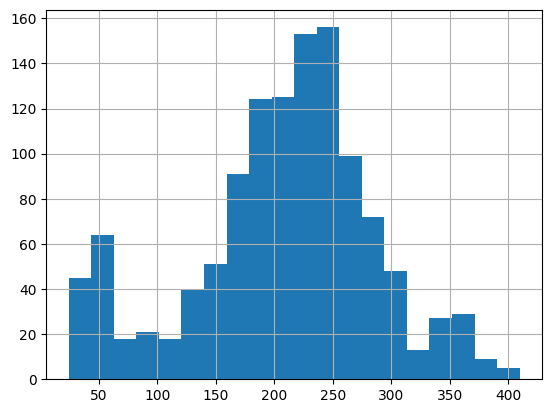

In [21]:
tesla_data[var].hist(bins=20)

<Axes: >

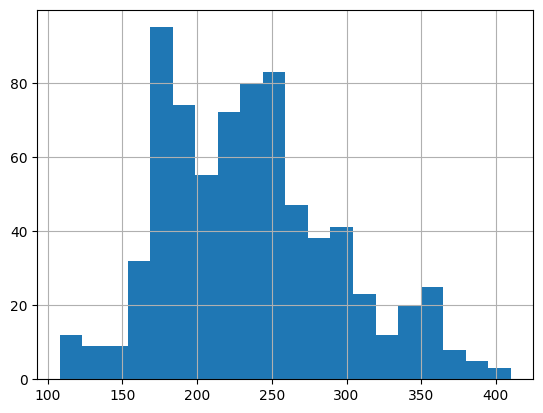

In [22]:
tesla_data_2[var].hist(bins=20)

##### Dispersion moyenne

In [24]:
tesla_data[var].std()/tesla_data[var].mean()*100

38.10054529226824

In [25]:
tesla_data_2[var].std()/tesla_data_2[var].mean()*100

24.685911613174227

Nos données sont homogènes.

##### Courbe de densité

<Axes: ylabel='Density'>

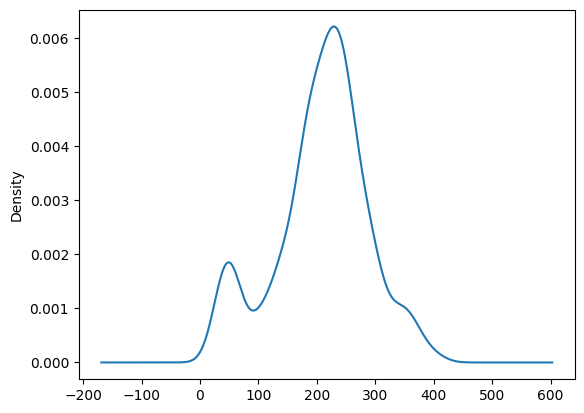

In [26]:
tesla_data[var].plot(kind="density")

<Axes: ylabel='Density'>

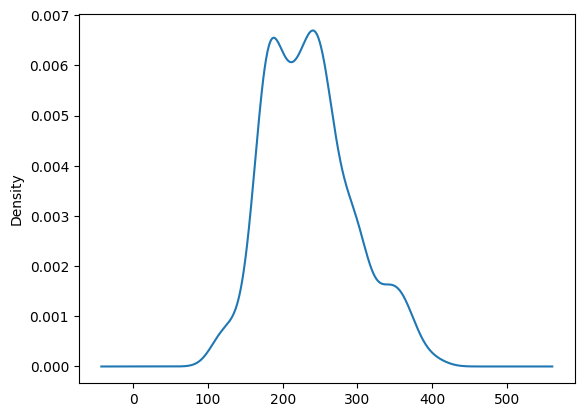

In [27]:
tesla_data_2[var].plot(kind="density")

##### Analyse des données aberrantes

In [46]:
-----

Minimum: 46.6 - Ouliers existants : 49
Maximum: 380.87 - Ouliers existants : 11
### Il y a 60 valeurs aberrantes.


<Axes: >

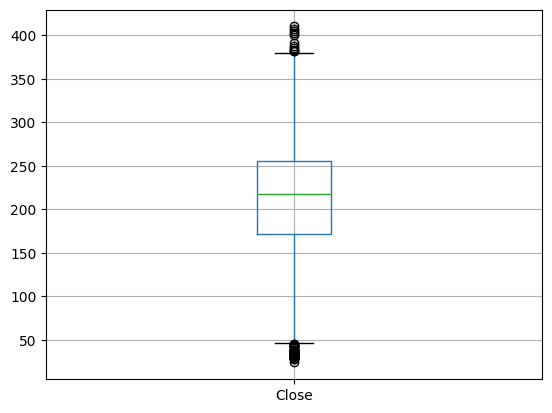

In [47]:
tesla_data.boxplot(var)

In [48]:
pd.DataFrame(pd.concat([outlmin , outlmax], axis = 0)).head(10)

,Close
Date,
2020-01-02,28.684000
2020-01-03,29.534000
2020-01-06,30.102667
2020-01-07,31.270666
2020-01-08,32.809334
2020-01-09,32.089333
2020-01-10,31.876667
2020-01-13,34.990665
2020-01-14,35.861332


In [49]:
---

Minimum: 43.84 - Pas d'ouliers
Maximum: 413.94 - Pas d'ouliers
### Il y a 0 valeurs aberrantes.


<Axes: >

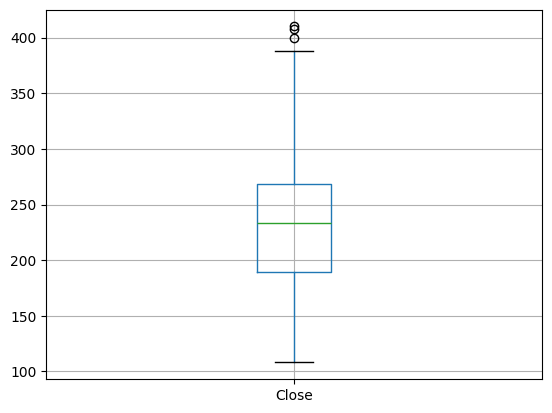

In [50]:
tesla_data_2.boxplot(var)

In [51]:
pd.DataFrame(pd.concat([outlmin , outlmax], axis = 0)).head(10)

,Close
Date,


## Étape 3: Les tests, la saisonnalité, la tendance et le bruit.

##### Les test de normalité

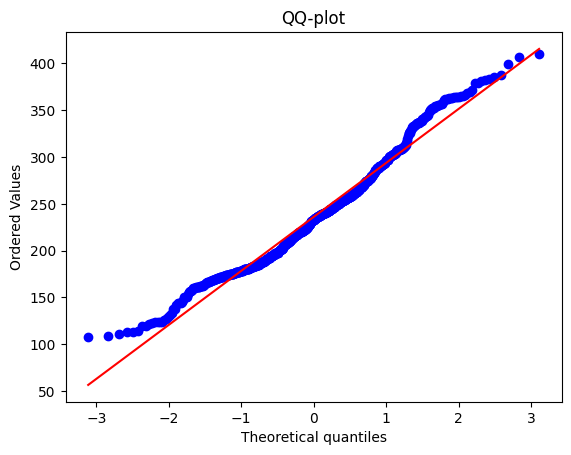

In [33]:
st.probplot(tesla_data[var], dist="norm", plot=plt)
plt.title("QQ-plot")
plt.show()

In [34]:
stat, p_value = shapiro(tesla_data[var])
print(f'Statistiques de Shapiro-Wilk: {stat}')
print(f'P-value: {p_value}')
print("### La série n'est pas normale (p-value<0,05)")

Statistiques de Shapiro-Wilk: 0.9754762859727959
P-value: 7.812197938336592e-10
### La série n'est pas normale (p-value<0,05)


In [35]:
ks, p_value = st.kstest(tesla_data[var], 'norm')
print(f'Statistique de Kolmogorov-Smirnov: {stat}')
print(f'P-value: {p_value}')
print("### La série n'est pas normale (p-value<0,05)")

Statistique de Kolmogorov-Smirnov: 0.9754762859727959
P-value: 0.0
### La série n'est pas normale (p-value<0,05)


**Conclusion** : </br>
La distribution des valeurs suit généralement la loi normale (les statistiques des deux  test tendent vers 1 et la courbe du QQ-plot suit la linéarité de la droite de normalité.</br>
Cependant les deux P-value des tests de Shapiro-Wilk et de Kolmogorov-Smirnov convergent vers la conclusion que cette série n'est pas issue du hasard.</br>
==> <u>Nous pouvons d'ores et déjà se poser la question de l'influence de facteurs exogènes.</u>

##### La tendance

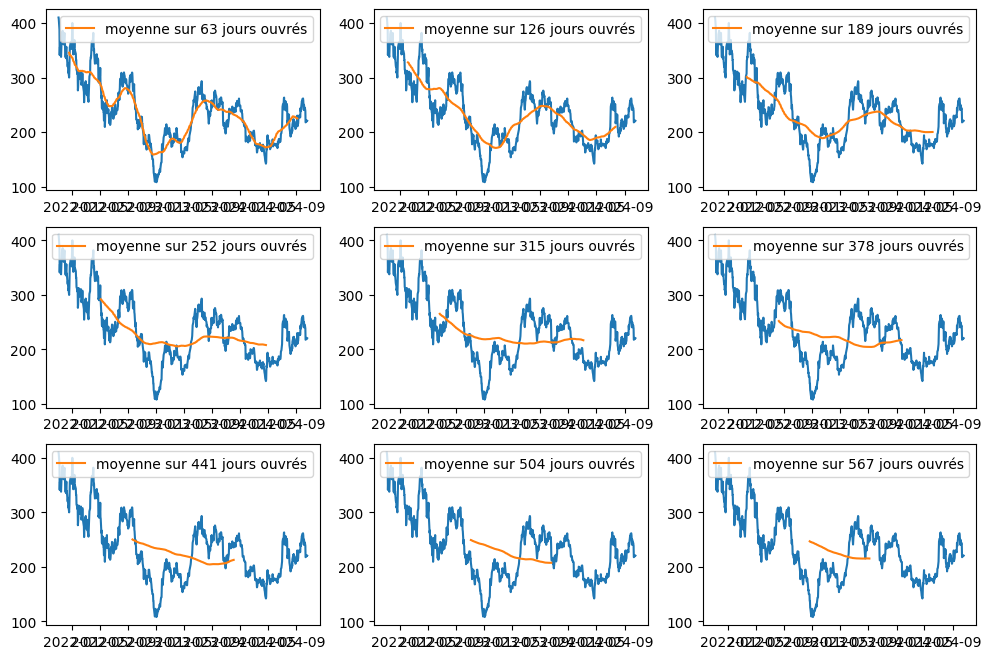

In [36]:
win = [63, 126, 189, 252, 315, 378, 441, 504, 567]
fig = plt.figure(figsize=(12,8))

for i in range(len(win)):
    ax = fig.add_subplot(3, 3, i+1)
    ax.plot(tesla_data[var])
    ax.plot(tesla_data[var].rolling(win[i], center=True).mean(), label=f"moyenne sur {win[i]} jours ouvrés")
    ax.legend()

##### La saisonnalité

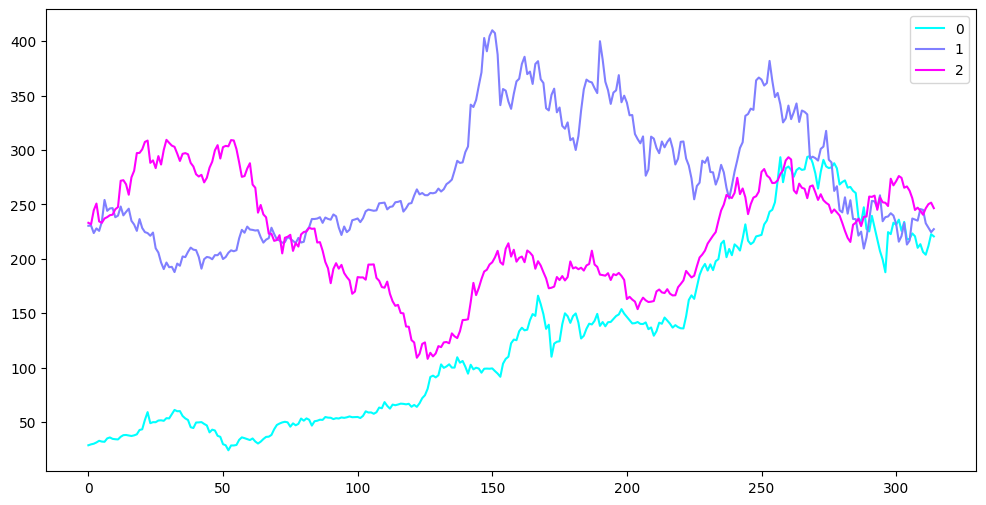

In [58]:
# Une optimisation de la recherche de saisonalité est prévue.

y = tesla_data[var]
nbr_jours_saison = 315

# Construction du tableau 
liste_positions = [x for x in range(nbr_jours_saison)]
# Modification (--Code de base : liste_saisons = [w for w in range(round(len(y)/nbr_jours_saison)+1)]--)
liste_saisons = [w for w in range(floor(len(y)/nbr_jours_saison))]
df_y = pd.DataFrame(y).reset_index()
liste1, liste2 = ([], [])
def position_saison(liste1, liste2, position, saison): liste1.append(position), liste2.append(saison)
[[position_saison(liste1, liste2, position, saison) for position in liste_positions] for saison in liste_saisons] #  if len(df_y.loc[(saison,)])==nbr_jours_saison
df_y[['Position', 'Saison']] = pd.DataFrame({'Position':liste1, 'Saison' : liste2})
df_y.set_index(['Saison', 'Position'], inplace=True)
# Supprimer les lignes dont l'index est NaN.     
if len(y) % nbr_jours_saison != 0 : df_y = df_y[~np.array([(pd.isna(idx[0]) or pd.isna(idx[1])) for idx in df_y.index])]

pst = df_y.index.get_level_values('Position').unique().astype(int)
sns = df_y.index.get_level_values('Saison').unique().astype(int)
colors = plt.cm.cool(np.linspace(0,1,len(sns)))
plt.figure(figsize=(12, 6))
for i in range(len(sns)):
    plt.plot(pst, df_y.loc[sns[i],'Close'], label=sns[i], color=colors[i])
    plt.legend(bbox_to_anchor=(1,1))

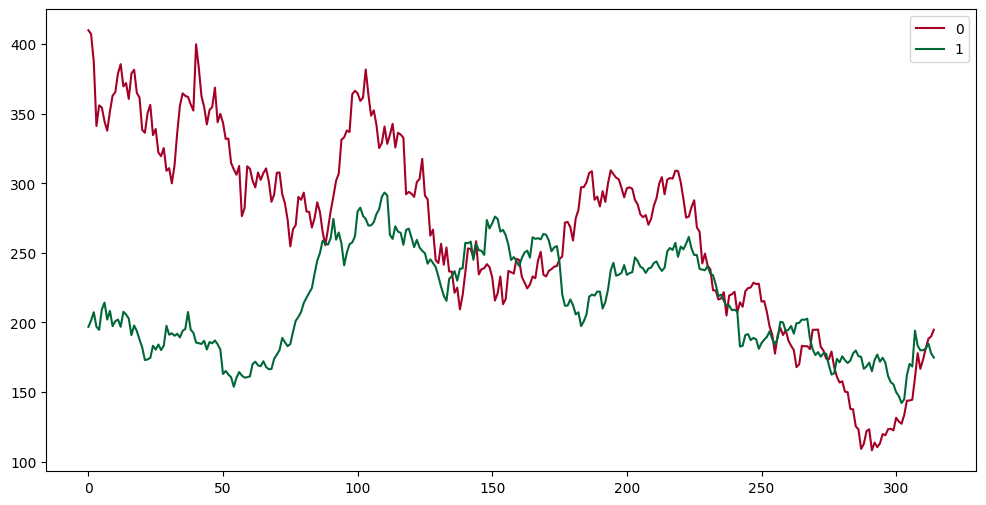

In [53]:
y = tesla_data_2[var]
nbr_jours_saison = 315

# Construction du tableau 
liste_positions = [x for x in range(nbr_jours_saison)]
# Modification (--Code de base : liste_saisons = [w for w in range(round(len(y)/nbr_jours_saison)+1)]--)
liste_saisons = [w for w in range(floor(len(y)/nbr_jours_saison))]
df_y = pd.DataFrame(y).reset_index()
liste1, liste2 = ([], [])
def position_saison(liste1, liste2, position, saison): liste1.append(position), liste2.append(saison)
[[position_saison(liste1, liste2, position, saison) for position in liste_positions] for saison in liste_saisons] #  if len(df_y.loc[(saison,)])==nbr_jours_saison
df_y[['Position', 'Saison']] = pd.DataFrame({'Position':liste1, 'Saison' : liste2})
df_y.set_index(['Saison', 'Position'], inplace=True)
# Supprimer les lignes dont l'index est NaN.     
if len(y) % nbr_jours_saison != 0 : df_y = df_y[~np.array([(pd.isna(idx[0]) or pd.isna(idx[1])) for idx in df_y.index])]

pst = df_y.index.get_level_values('Position').unique().astype(int)
sns = df_y.index.get_level_values('Saison').unique().astype(int)
colors = plt.cm.RdYlGn(np.linspace(0,1,len(sns)))
plt.figure(figsize=(12, 6))
for i in range(len(sns)):
    plt.plot(pst, df_y.loc[sns[i],'Close'], label=sns[i], color=colors[i])
    plt.legend(bbox_to_anchor=(1,1))

##### La stationnarité

In [94]:
result1 = adfuller(tesla_data[var])
print(f'Statistiques ADF: {result1[0]}')
print(f'P-value: {result1[1]}')
print(f'Valeurs Critiques: {result1[4]}')

Statistiques ADF: -2.668975492925413
P-value: 0.07956243613332781
Valeurs Critiques: {'1%': -3.4358248361156765, '5%': -2.8639575982634757, '10%': -2.5680571735171958}


In [96]:
result3 = kpss(tesla_data[var])
print(f"Test Statistic: {result3[0]}")
print(f"P-value: {result3[1]}")
print(f"Valeurs Critiques: {result3[3]}")

Test Statistic: 1.4246099332139517
P-value: 0.01
Valeurs Critiques: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


In [95]:
result2 = adfuller(tesla_data_2[var])
print(f'Statistiques ADF: {result2[0]}')
print(f'P-value: {result2[1]}')
print(f'Valeurs Critiques: {result2[4]}')

Statistiques ADF: -2.9520822810606417
P-value: 0.039618135687715716
Valeurs Critiques: {'1%': -3.439314999916068, '5%': -2.8654965012008677, '10%': -2.5688768817372867}


In [97]:
result4 = kpss(tesla_data_2[var])
print(f"Test Statistic: {result4[0]}")
print(f"P-value: {result4[1]}")
print(f"Valeurs Critiques: {result4[3]}")

Test Statistic: 1.6136167919340796
P-value: 0.01
Valeurs Critiques: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


**Conclusion** : </br>
<u>Valeurs de Tesla entre 2020 et Aujourd'hui</u> (Tesla_data) :</br>
P-value[ADF] > 0,05   |   P-value[kpss] < 0,05</br>
===> Les deux test convergent à dire que cette distribution n'est pas stationnaire.</br>
<u>Valeurs de Tesla entre 2022 et Aujourd'hui</u> (Tesla_data_2) :</br>
P-value[ADF] < 0,05   |   P-value[kpss] < 0,05</br>
===> La P-value du test ADF stipule que la série est stationnaire alors que celle du test KPSS avance le contraire.</br>
(Statistique ADF = -2.95) < (Valeur critique ADF = -2.86) --- (Statistique KPSS = 1.61) > (Valeur critique KPSS = 0.46)</br>
===> La statistique du test ADF stipule que la série est stationnaire alors que celle du test KPSS lui répond par la négative.

##### Autocorrélation et autocorrélation partielle

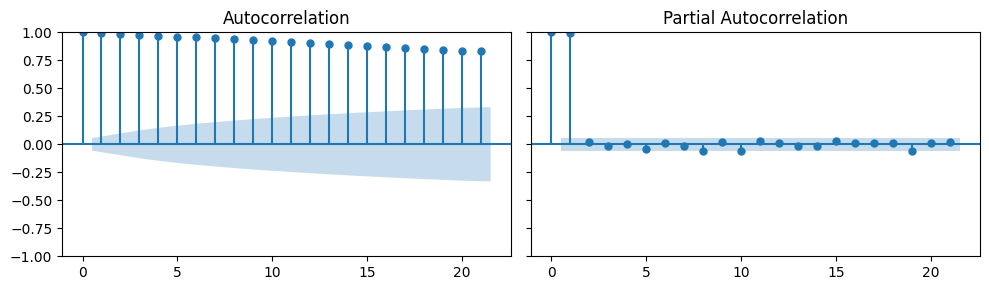

In [130]:
# Il serait intéressant de rajouter les dates sur l'axe des X sur les graphiques de l'autocorrelation et autocorrelation partielle (projet).

fig, axes = plt.subplots(1, 2, sharey=True, sharex=True)
fig.set_figwidth(10)
fig.set_figheight(3)
smt.graphics.plot_acf(tesla_data[var], lags=21, ax=axes[0])
smt.graphics.plot_pacf(tesla_data[var], lags=21 , ax=axes[1])
plt.tight_layout()

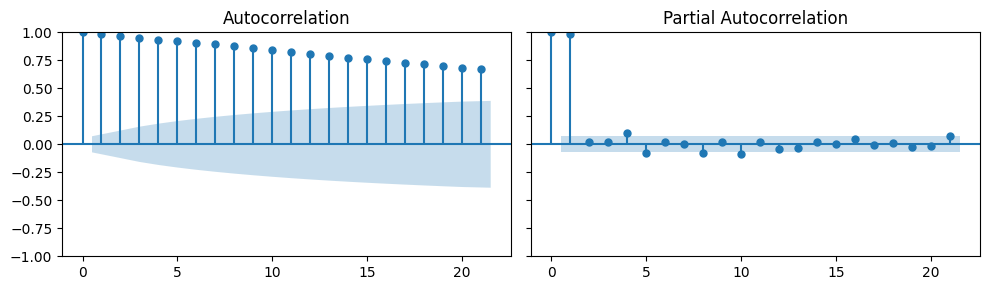

In [77]:
fig, axes = plt.subplots(1, 2, sharey=True, sharex=True)
fig.set_figwidth(10)
fig.set_figheight(3)
smt.graphics.plot_acf(tesla_data_2[var], lags=21, ax=axes[0])
smt.graphics.plot_pacf(tesla_data_2[var], lags=21 , ax=axes[1])
plt.tight_layout()

**Conclusion** : </br>
Le graphique de l'auto-corrélation ne retranscrit aucune saisonnalité en l'état, pour aucune des séries. Optons pour une stationnarisation des deux séries.</br>

##### Stationnarisation des variables :

##### Série 2020 :

In [153]:
diff_tesla_data = tesla_data[var].diff().dropna()

result5 = adfuller(diff_tesla_data)
print(f"Test Statistic ADF: {result5[0]}")
print(f"P-value ADF: {result5[1]}")
print(f"Valeurs Critique ADFs: {result5[4]}")
result6 = kpss(diff_tesla_data)
print(f"Test Statistic KPSS: {result6[0]}")
print(f"P-value KPSS: {result6[1]}")
print(f"Valeurs Critiques KPSS: {result6[3]}")

Test Statistic ADF: -6.856510799236478
P-value ADF: 1.6432128290517708e-09
Valeurs Critique ADFs: {'1%': -3.4358897684764886, '5%': -2.8639862448409055, '10%': -2.5680724298154542}
Test Statistic KPSS: 0.15029045401653443
P-value KPSS: 0.1
Valeurs Critiques KPSS: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


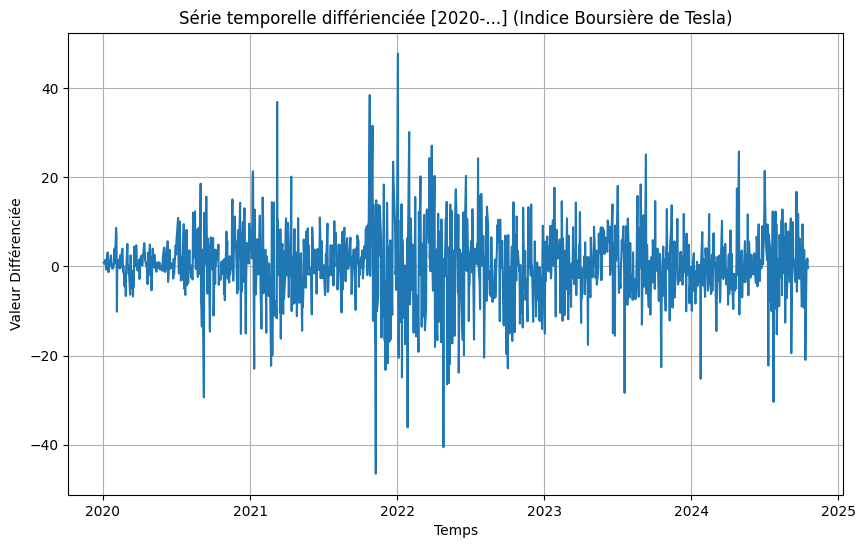

In [139]:
plt.figure(figsize=(10, 6))
plt.plot(diff_tesla_data)
plt.title('Série temporelle différienciée [2020-...] (Indice Boursière de Tesla)')
plt.xlabel('Temps')
plt.ylabel('Valeur Différenciée')
plt.grid(True)
plt.show()

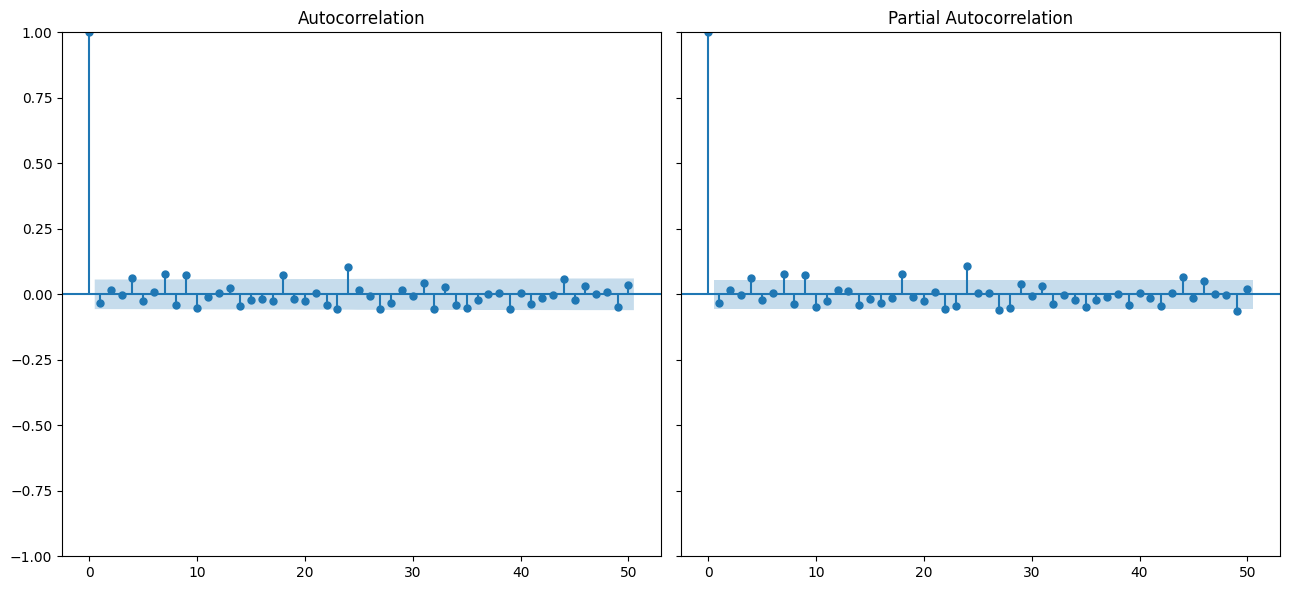

In [140]:
fig, axes = plt.subplots(1, 2, sharey=True, sharex=True)
fig.set_figwidth(13)
fig.set_figheight(6)
smt.graphics.plot_acf(diff_tesla_data, lags=50, ax=axes[0])
smt.graphics.plot_pacf(diff_tesla_data, lags=50 , ax=axes[1])
plt.tight_layout()

Les tests ADF et KPSS sont en contradiction, le graphe nous présente une réprésentation des valeurs stationnaires et l'autocorrélation semble acceptable.

##### Série 2022 :

In [154]:
diff_tesla_data_2 = tesla_data_2[var].diff().dropna()

result7 = adfuller(diff_tesla_data_2)
print(f"Test Statistic ADF: {result7[0]}")
print(f"P-value ADF: {result7[1]}")
print(f"Valeurs Critique ADFs: {result7[4]}")
result8 = kpss(diff_tesla_data_2)
print(f"Test Statistic KPSS: {result8[0]}")
print(f"P-value KPSS: {result8[1]}")
print(f"Valeurs Critiques KPSS: {result8[3]}")

Test Statistic ADF: -8.146373437856948
P-value ADF: 9.963590595521293e-13
Valeurs Critique ADFs: {'1%': -3.439314999916068, '5%': -2.8654965012008677, '10%': -2.5688768817372867}
Test Statistic KPSS: 0.15183921491957159
P-value KPSS: 0.1
Valeurs Critiques KPSS: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


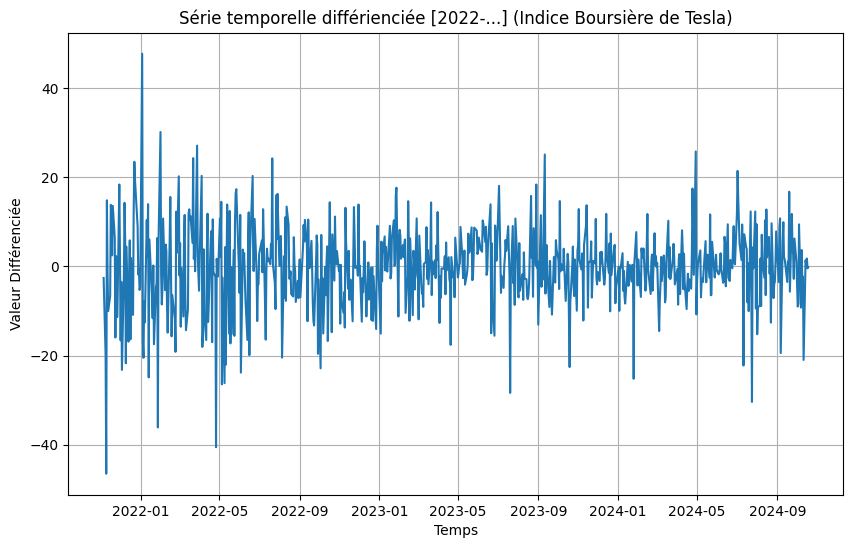

In [142]:
plt.figure(figsize=(10, 6))
plt.plot(diff_tesla_data_2)
plt.title('Série temporelle différienciée [2022-...] (Indice Boursière de Tesla)')
plt.xlabel('Temps')
plt.ylabel('Valeur Différenciée')
plt.grid(True)
plt.show()

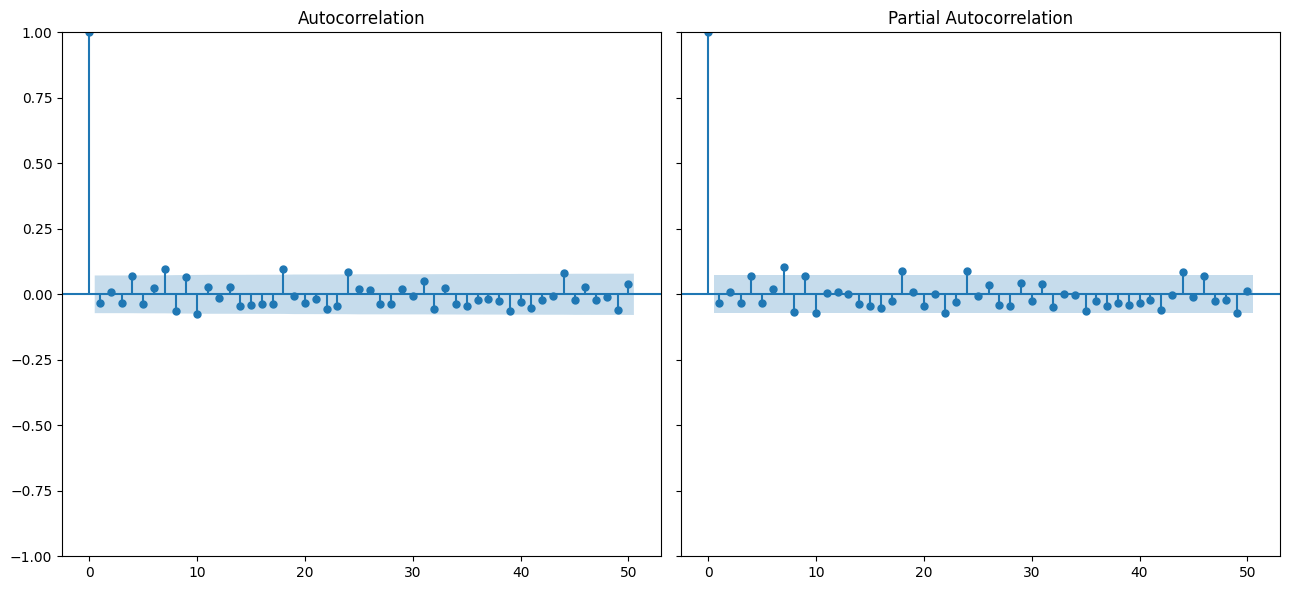

In [143]:
fig, axes = plt.subplots(1, 2, sharey=True, sharex=True)
fig.set_figwidth(13)
fig.set_figheight(6)
smt.graphics.plot_acf(diff_tesla_data_2, lags=50, ax=axes[0])
smt.graphics.plot_pacf(diff_tesla_data_2, lags=50 , ax=axes[1])
plt.tight_layout()

Même conclusions que précédemment :</br>
Les tests ADF et KPSS sont en accord sur la stationnarité des séries 2020 et 2022, le graphe nous présente une réprésentation des valeurs stationnaires et l'autocorrélation semble acceptable.

##### 2ème stationnarisation des variables : A titre indicatif.

##### Série 2020 : A titre indicatif.

In [155]:
diff2_tesla_data = diff_tesla_data.diff().dropna()

result9 = adfuller(diff2_tesla_data)
print(f"Test Statistic ADF: {result9[0]}")
print(f"P-value ADF: {result9[1]}")
print(f"Valeurs Critique ADFs: {result9[4]}")
result10 = kpss(diff2_tesla_data)
print(f"Test Statistic KPSS: {result10[0]}")
print(f"P-value KPSS: {result10[1]}")
print(f"Valeurs Critiques KPSS: {result10[3]}")

Test Statistic ADF: -12.349684650037622
P-value ADF: 5.863585023088574e-23
Valeurs Critique ADFs: {'1%': -3.4358944654892474, '5%': -2.86398831702468, '10%': -2.5680735334014733}
Test Statistic KPSS: 0.018238153026335878
P-value KPSS: 0.1
Valeurs Critiques KPSS: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


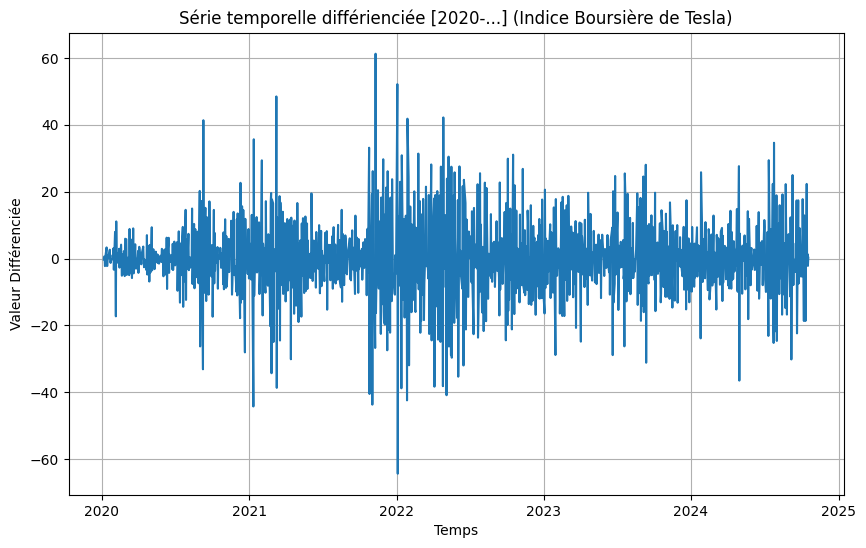

In [145]:
plt.figure(figsize=(10, 6))
plt.plot(diff2_tesla_data)
plt.title('Série temporelle différienciée [2020-...] (Indice Boursière de Tesla)')
plt.xlabel('Temps')
plt.ylabel('Valeur Différenciée')
plt.grid(True)
plt.show()

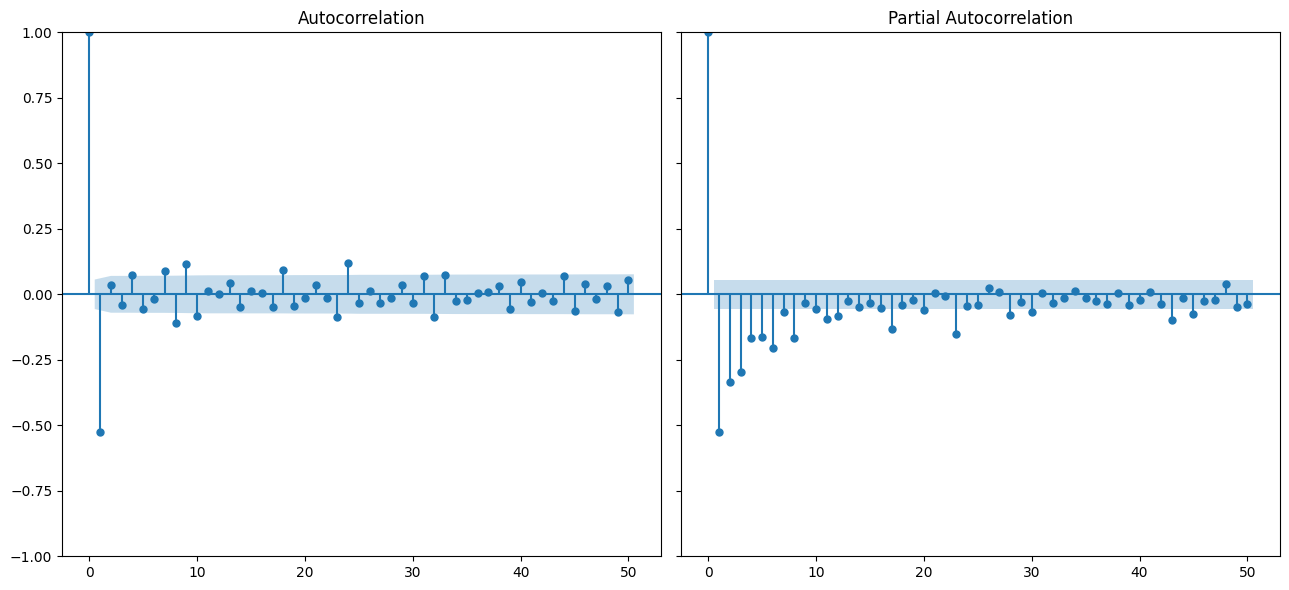

In [146]:
fig, axes = plt.subplots(1, 2, sharey=True, sharex=True)
fig.set_figwidth(13)
fig.set_figheight(6)
smt.graphics.plot_acf(diff2_tesla_data, lags=50, ax=axes[0])
smt.graphics.plot_pacf(diff2_tesla_data, lags=50 , ax=axes[1])
plt.tight_layout()

Les tests ADF et KPSS sont en contradiction, le graphe nous présente une réprésentation des valeurs stationnaires et l'autocorrélation semble acceptable.

##### Série 2022 : A titre indicatif.

In [156]:
diff2_tesla_data_2 = diff_tesla_data_2.diff().dropna()

result11 = adfuller(diff2_tesla_data_2)
print(f"Test Statistic ADF: {result11[0]}")
print(f"P-value ADF: {result11[1]}")
print(f"Valeurs Critique ADFs: {result11[4]}")
result12 = kpss(diff2_tesla_data_2)
print(f"Test Statistic KPSS: {result12[0]}")
print(f"P-value KPSS: {result12[1]}")
print(f"Valeurs Critiques KPSS: {result12[3]}")

Test Statistic ADF: -10.835237565518108
P-value ADF: 1.6685674434010246e-19
Valeurs Critique ADFs: {'1%': -3.4394269973845657, '5%': -2.8655458544300387, '10%': -2.568903174551249}
Test Statistic KPSS: 0.020294145550455046
P-value KPSS: 0.1
Valeurs Critiques KPSS: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


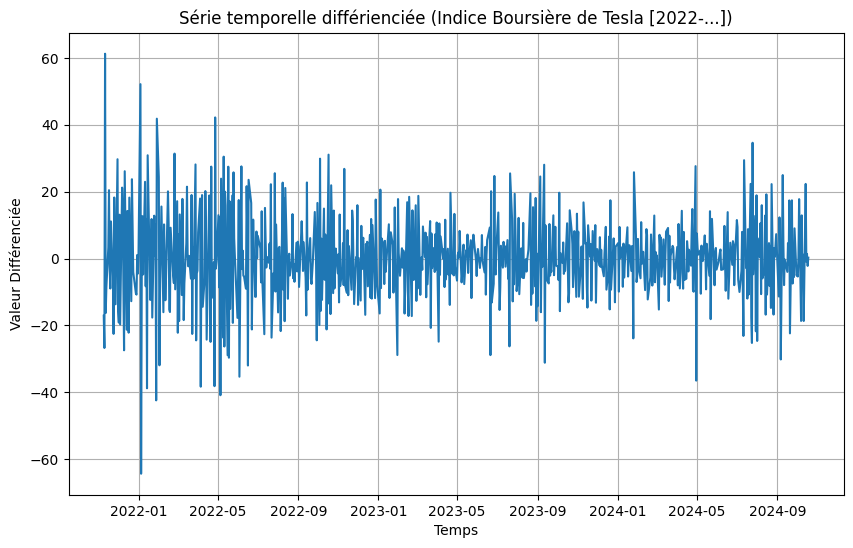

In [149]:
plt.figure(figsize=(10, 6))
plt.plot(diff2_tesla_data_2)
plt.title('Série temporelle différienciée (Indice Boursière de Tesla [2022-...])')
plt.xlabel('Temps')
plt.ylabel('Valeur Différenciée')
plt.grid(True)
plt.show()

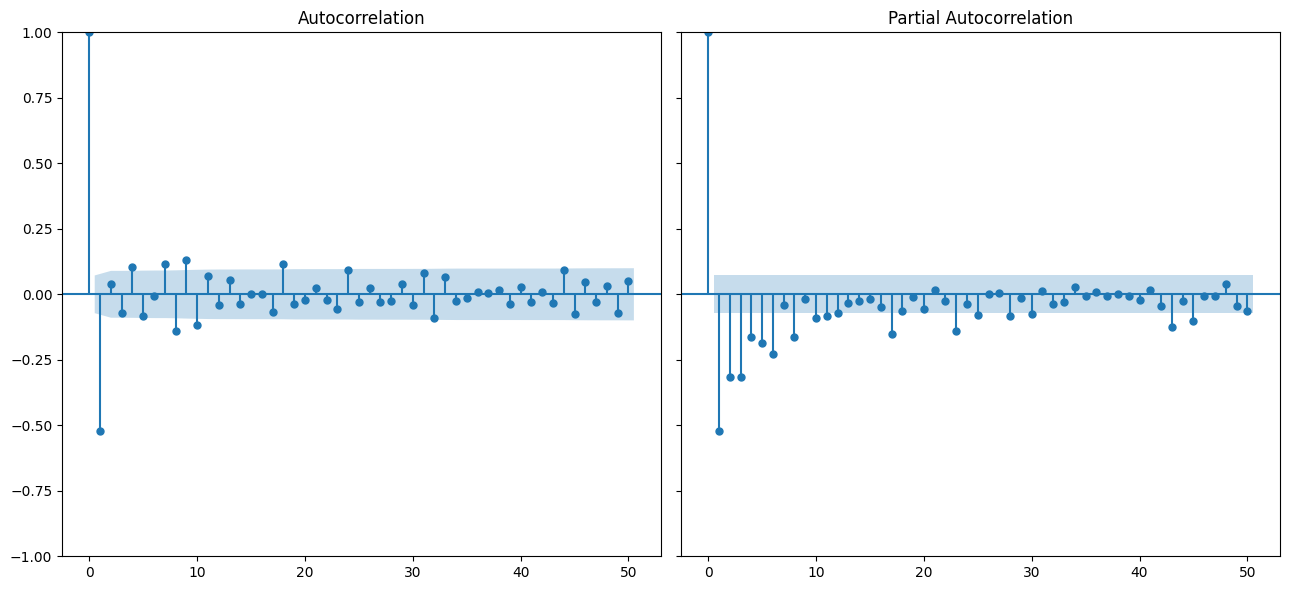

In [150]:
fig, axes = plt.subplots(1, 2, sharey=True, sharex=True)
fig.set_figwidth(13)
fig.set_figheight(6)
smt.graphics.plot_acf(diff2_tesla_data_2, lags=50, ax=axes[0])
smt.graphics.plot_pacf(diff2_tesla_data_2, lags=50 , ax=axes[1])
plt.tight_layout()

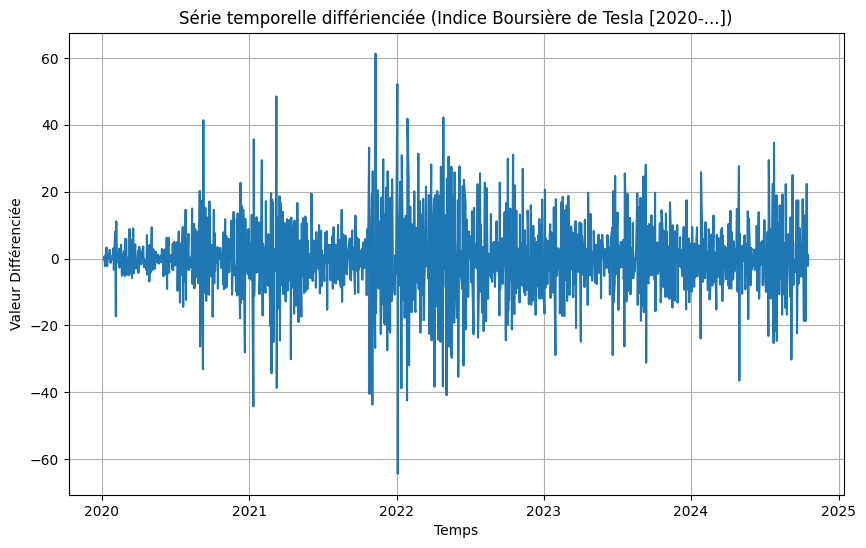

In [125]:
plt.figure(figsize=(10, 6))
plt.plot(diff2_tesla_data)
plt.title('Série temporelle différienciée (Indice Boursière de Tesla [2020-...])')
plt.xlabel('Temps')
plt.ylabel('Valeur Différenciée')
plt.grid(True)
plt.show()

##### Décomposition saisonnière

In [67]:
# Nombre de jours dans une année selon les données de notre dataset :
print(len(tesla_data.loc['2020-06-01':'2021-05-31',]))
print(len(tesla_data.loc['2021-06-01':'2022-05-31',]))
print(len(tesla_data.loc['2023-06-01':'2024-05-31',]))

252
253
252


##### 2020 - Stationnaire - Période de 21 jours : 

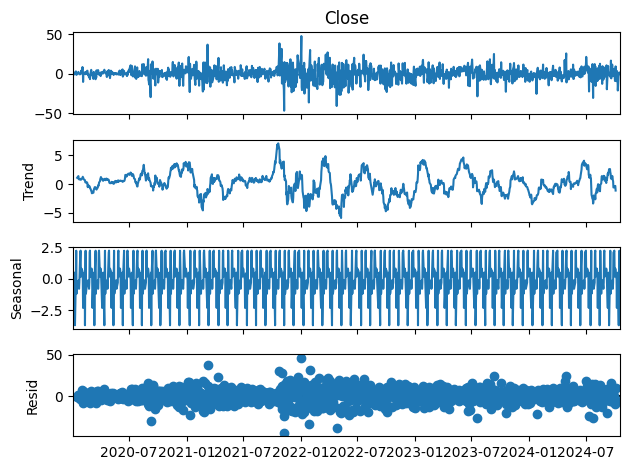

In [83]:
# period=21
decomposition = sm.tsa.seasonal_decompose(diff_tesla_data, model='additive', period=21)
fig = decomposition.plot()
plt.show()

##### 2022 - Stationnaire - Période de 21 jours : 

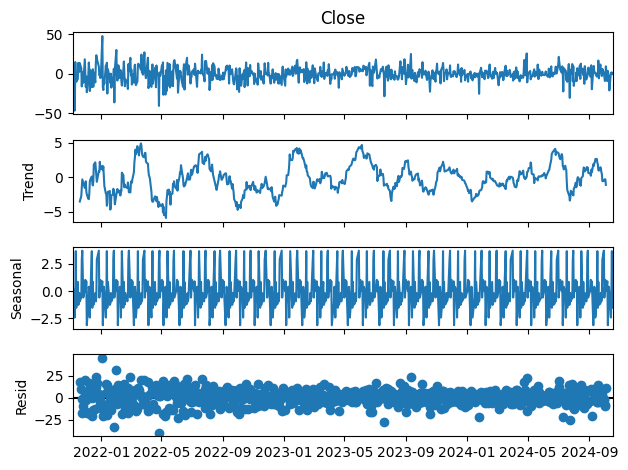

In [84]:
# period=21
decomposition = sm.tsa.seasonal_decompose(diff_tesla_data_2, model='additive', period=21)
fig = decomposition.plot()
plt.show()

##### 2020 - Stationnaire - Période de 252 jours : 

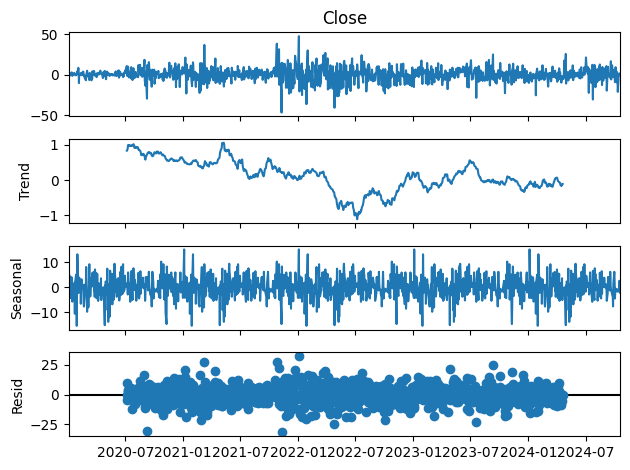

In [85]:
# period=252
decomposition = sm.tsa.seasonal_decompose(diff_tesla_data, model='additive', period=252)
fig = decomposition.plot()
plt.show()

##### 2022 - Stationnaire - Période de 252 jours : 

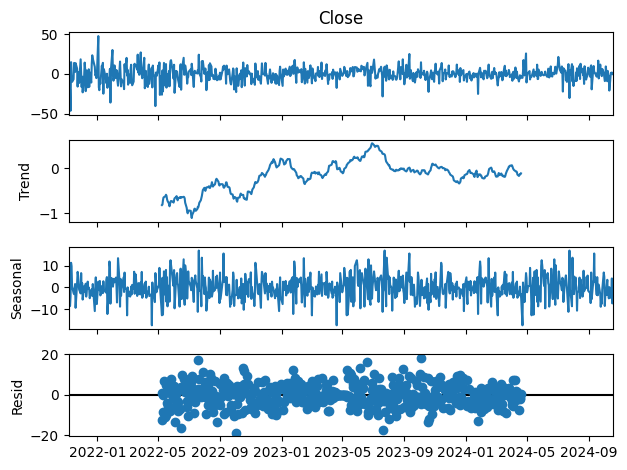

In [86]:
# period=252
decomposition = sm.tsa.seasonal_decompose(diff_tesla_data_2, model='additive', period=252)
fig = decomposition.plot()
plt.show()

--> La stationnarité n'est pas tout à fait visible, mais on peux en entrevoir une.

##### 2020 - Stationnaire - Période de 315 jours : 

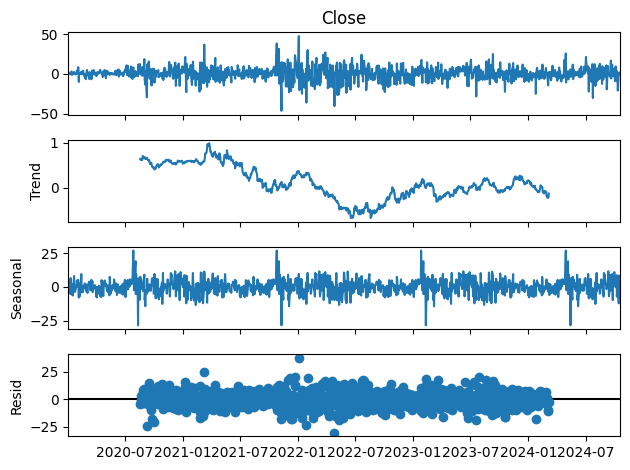

In [159]:
# period=315
decomposition = sm.tsa.seasonal_decompose(diff_tesla_data, model='additive', period=315)
fig = decomposition.plot()
plt.show()

##### 2022 - Stationnaire - Période de 315 jours : 

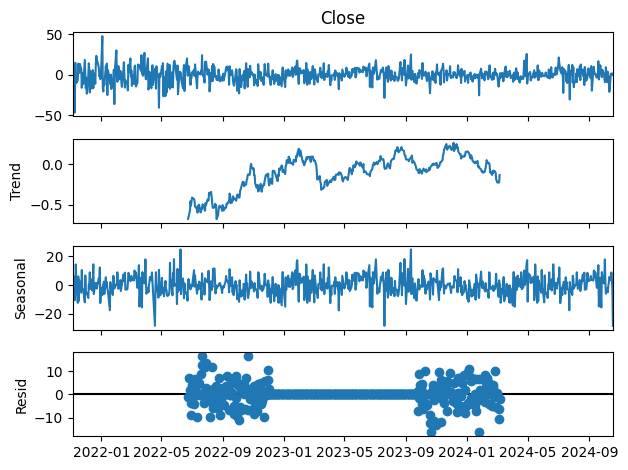

In [160]:
# period=315
decomposition = sm.tsa.seasonal_decompose(diff_tesla_data_2, model='additive', period=315)
fig = decomposition.plot()
plt.show()

##### 2020 - Stationnarisé 2 fois - Période de 252 jours : A titre indicatif

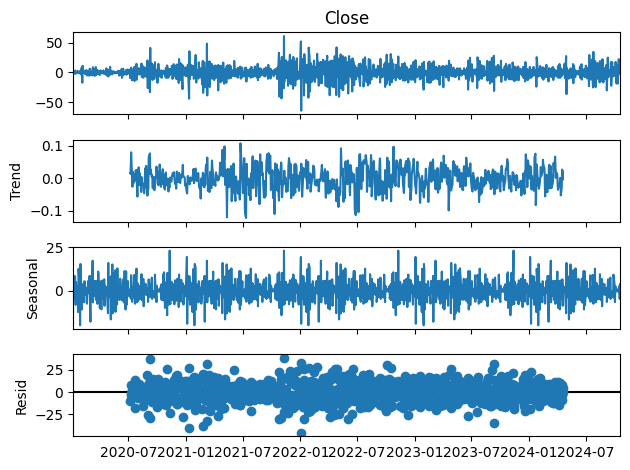

In [158]:
# period=252
decomposition = sm.tsa.seasonal_decompose(diff2_tesla_data, model='additive', period=252)
fig = decomposition.plot()
plt.show()

##### 2022 - Stationnarisé 2 fois - Période de 252 jours : A titre indicatif

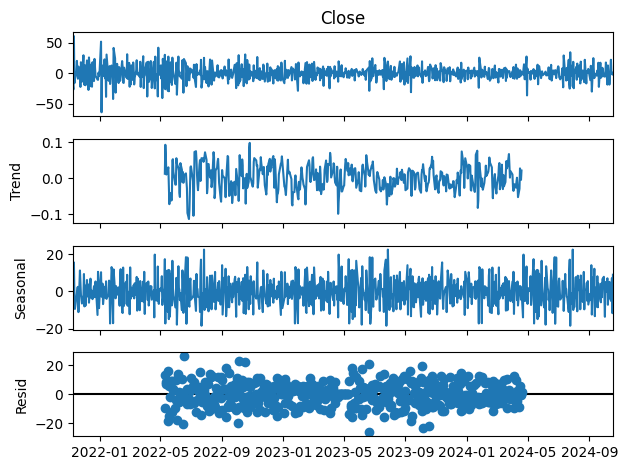

In [161]:
# period=252
decomposition = sm.tsa.seasonal_decompose(diff2_tesla_data_2, model='additive', period=252)
fig = decomposition.plot()
plt.show()

D'autres outils aident à la recherche de saisonnalité comme le test de Chow.

## Étape 5: Modélisation prédictive

In [251]:
y = tesla_data[var]
val = round(len(y)*80/100)
y_train = y[:val]
y_test = y[val:]
print(f"Nombre de données des valeurs de 2020 non stationnaire : {(len(y_train), len(y_test))}")

Nombre de données des valeurs de 2020 non stationnaire : (966, 242)


## Étape 5.1: Modélisation prédictive - Lissage Exponentiel


In [252]:
# Après de multiples essais pour le choix de la longueur de saisonnalité et en comparant les résultats de l'erreur relative moyenne,
# Deux valeurs ont des résultats acceptables : 367 et 371.
sp=315

results_ExpSmooth = ExponentialSmoothing(y_train, seasonal_periods=sp, trend='add', seasonal='add').fit()
results_ExpSmooth.summary()

Dep. Variable:,Close,No. Observations:,966
Model:,ExponentialSmoothing,SSE,47346.318
Optimized:,True,AIC,4397.750
Trend:,Additive,BIC,5952.289
Seasonal:,Additive,AICC,4718.750
Seasonal Periods:,315,Date:,"Mon, 21 Oct 2024"
Box-Cox:,False,Time:,04:52:13
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9466366,alpha,True
smoothing_trend,0.0007403,beta,True


In [290]:
# Calcul est prévisions
y_predict_ExpSmooth = results_ExpSmooth.forecast(len(test))
y_predict_ExpSmooth

966     209.817135
967     212.870093
968     202.395944
969     205.003711
970     198.363621
           ...    
1203    300.842102
1204    309.119723
1205    314.389086
1206    308.288335
1207    298.685728
Length: 242, dtype: float64

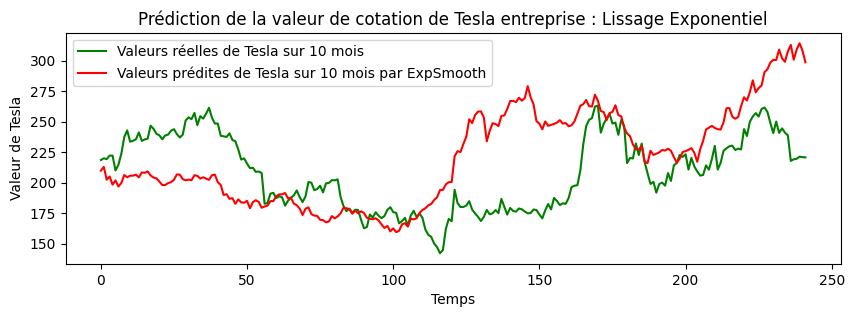

In [292]:
plt.figure(figsize=(10,3))
plt.plot(test.values, label='Valeurs réelles de Tesla sur 10 mois', color='green')
plt.plot(y_predict_ExpSmooth.values, label='Valeurs prédites de Tesla sur 10 mois par ExpSmooth', color='red')
plt.ylabel('Valeur de Tesla')
plt.xlabel('Temps')
plt.title('Prédiction de la valeur de cotation de Tesla entreprise : Lissage Exponentiel')
plt.legend(loc='best')
plt.show()

In [293]:
# Analyse des valeurs réelles, prédites et de l'errur absolue et relative.
resultat_ExpSmooth=pd.DataFrame()
resultat_ExpSmooth["realite"]=test
resultat_ExpSmooth["prevision"]=y_predict_ExpSmooth.values
resultat_ExpSmooth["erreur_absolue"]=resultat_ExpSmooth["prevision"]-resultat_ExpSmooth["realite"]
resultat_ExpSmooth["erreur_relative"]=resultat_ExpSmooth["erreur_absolue"]/resultat_ExpSmooth["realite"]*100

resultat_ExpSmooth

,realite,prevision,erreur_absolue,erreur_relative
Date,,,,
2023-11-02,218.509995,209.817135,-8.692860,-3.978244
2023-11-03,219.960007,212.870093,-7.089913,-3.223274
2023-11-06,219.270004,202.395944,-16.874060,-7.695562
2023-11-07,222.179993,205.003711,-17.176282,-7.730796
2023-11-08,222.110001,198.363621,-23.746380,-10.691270
...,...,...,...,...
2024-10-14,219.160004,300.842102,81.682098,37.270532
2024-10-15,219.570007,309.119723,89.549715,40.784129
2024-10-16,221.330002,314.389086,93.059084,42.045400


<Axes: title={'center': 'erreur_relative'}, xlabel='Date'>

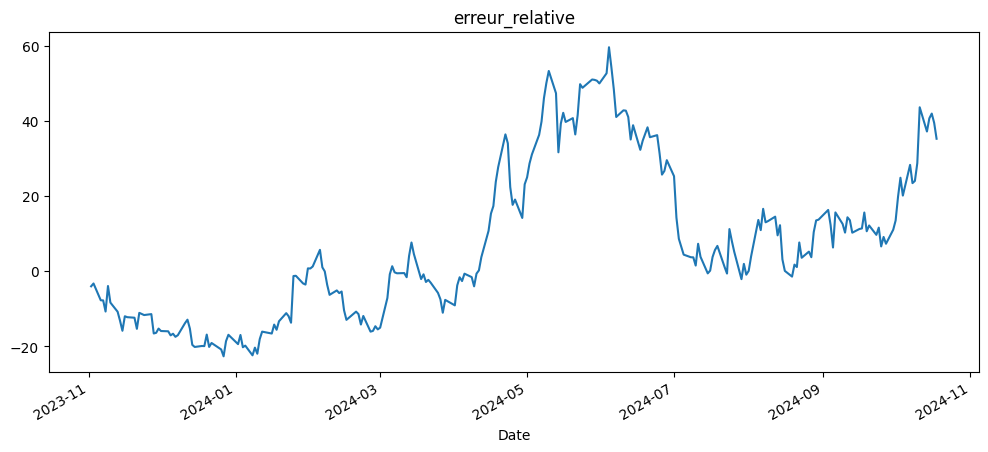

In [294]:
# Visualisation des erreurs
resultat_ExpSmooth['erreur_relative'].plot(kind='line', figsize=(12, 5), title='erreur_relative')

<Axes: >

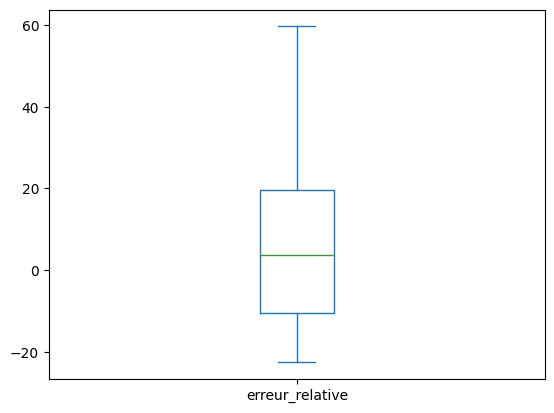

In [295]:
# Boxplot des erreurs
resultat_ExpSmooth['erreur_relative'].plot(kind="box")

# Il ne montre aucune valeur aberrante.

In [296]:
print(f"Erreur relative : {st.shapiro(resultat_ExpSmooth.erreur_relative)}")
print(f"Residu : ________ {st.shapiro(results_ExpSmooth.resid)}")

Erreur relative : ShapiroResult(statistic=0.9360365711839527, pvalue=9.16332124527604e-09)
Residu : ________ ShapiroResult(statistic=0.9862836778204481, pvalue=7.290579098673709e-08)


In [297]:
resultat_ExpSmooth.erreur_relative.mean()

7.456205983452708

##### On a une erreur relative de 5,8%. Nous pouvons avoir confiance en ce paramétrage à 94,2%

__________________________________________________________________